# Code to make heatmaps using latent representations of data in LLMs!

In [1]:
# for attention maps + hidden states
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from ripser import ripser
from tqdm import tqdm
import math
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for nlp
import spacy
import textdescriptives as td

# for heatmaps
from dcor import distance_correlation
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
import os

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# should first do the following in terminal for llama:
# 1. pip install huggingface_hub
# 2. huggingface-cli login --token <access_token>
# alt 2. hf auth login

# load in model! (modeled after Angelina's Code :))

def load_model(model_id = "meta-llama/Llama-3.1-8B-Instruct", device = "cuda"):
    """
    Load model and tokenizer, handling different architectures.
    """
    from transformers import AutoModelForCausalLM
    
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    
    # Set padding token if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    try:
        # for encoder-only models (BERT, RoBERTa, etc.)
        model = AutoModel.from_pretrained(
            model_id, 
            output_attentions=True,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32
        )
    except Exception:
        try:
            # For causal LM models (Llama, Qwen, GPT, etc.)
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                output_attentions=True,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                device_map="auto" if device == "cuda" else None
            )
        except Exception:
            # for seq2seq models (BART, T5, etc.)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_id,
                output_attentions=True,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32
            )
    
    model.to(device)
    model.eval()
    
    return model, tokenizer

In [3]:
def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf


def get_second_value_ignoring_inf(data):
    """
    Returns the second non-inf value in a list.

    Args:
      data: A list of numerical values.

    Returns:
      The second non-inf value in the list, or None if not found.
    """
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]

In [4]:
def get_attention(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    attention_matrices = torch.stack(outputs.attentions).mean(dim=0).squeeze().cpu().numpy()
    return np.mean(attention_matrices, axis=0)  # Averaging across heads

def get_embeddings(text, model, tokenizer):
    # get the intial tokenization (layer 0 embeddings)
    inputs = tokenizer(text=text, truncation=True, return_tensors="pt").to(model.device)

    # get first hidden state information
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    embeddings = outputs.hidden_states[0]
    
    return embeddings

def build_graph_attention(attention_matrix, threshold=0.1):
    graph = nx.Graph()
    num_nodes = attention_matrix.shape[0]

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if attention_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=attention_matrix[i, j])

    if graph.number_of_nodes() == 0:
        print("transposed matrix")
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if attention_matrix[j, i] > threshold:
                    graph.add_edge(i, j, weight=attention_matrix[i, j])
    
    adjacency_matrix = nx.to_numpy_array(graph)
    return adjacency_matrix

def build_graph_embeddings(embeddings):
    # # standardize embeddings
    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(-1, embeddings.shape[-1])
    
    # fit + transform PCA with 2 components
    graph_embeddings = PCA(n_components=2).fit_transform(embeddings)

    return graph_embeddings

def compute_tda_features(graph):
    diagrams = ripser(graph, maxdim=1)['dgms']

    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = np.count_nonzero(np.round(h0)) #count_nonzero(h0) #len(h0)
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    # Replace inf values with 0
    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0
    # print("mean h0: ", mean_h0)


    num_h1 = np.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    
    ## EDIT ##
    # set none values to 0 to avoid error
    highest_h1 = highest_h1 if highest_h1 is not None else 0
    second_highest_h1 = second_highest_h1 if second_highest_h1 is not None else 0
    ###    ###

    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    # Replace inf values with 0
    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0
    # print("mean h1: ", mean_h1)

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])

    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    # Additional TDA features for linguistic correlation
    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)


    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]
    
def process_texts(texts, lat_rep, model_id):
    """
    input: - texts: array of strings
           - lat_rep: string of which latent representation to use for PH analysis,
             valid arguments are "hs" for hidden states or "a" for attention
           - model_id: which model to use
    """
    model, tokenizer = load_model(model_id)
    
    data = []
    for text in tqdm(texts):
        if lat_rep == "hs":
            hidden_states = get_embeddings(text, model, tokenizer).cpu().detach().numpy()
            graph = build_graph_embeddings(hidden_states)
        elif lat_rep == "a":
            attention_matrix = get_attention(text, model, tokenizer)
            graph = build_graph_attention(attention_matrix)
        else:
            print("could not make a graph")
            return
        tda_features = compute_tda_features(graph)
        data.append(tda_features)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

# Example usage
texts = ["This is a test sentence.", "Another example of text processing."]
df = process_texts(texts, "a", "bert-base-uncased")

print(df)


`torch_dtype` is deprecated! Use `dtype` instead!
  0%|          | 0/2 [00:00<?, ?it/s]/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  7.90it/s]/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 15.36it/s]

   Num_0dim  Max_0dim  Max_0dim_Minus_Second  Mean_0dim  betti_curve_0  \
0         2  0.763900               0.684287   0.099306              8   
1         2  1.240592               1.123554   0.120313              8   

   persistence_entropy_0  Num_1dim  Max_1dim  Max_1dim_Minus_Second  \
0               1.690259         0         0                      0   
1               1.194369         0         0                      0   

   Mean_1dim  betti_curve_1  persistence_entropy_1  
0          0              1                   -0.0  
1          0              1                   -0.0  


In [5]:
# import dataset!!
# datasets: BLIMP, windograd, GLUE, 
datasets = ["~/tda_vs_linguistics/data/nyu_mll_blimp.csv",
            "~/tda_vs_linguistics/data/nyu_winograd_wsc.csv",
            "~/tda_vs_linguistics/data/nyu_mll_glue.csv",
            "~/tda_vs_linguistics/data/nyu_mll_multi.csv",
            "~/tda_vs_linguistics/data/galileo_snli.csv",
            "~/tda_vs_linguistics/data/aps_superglue.csv"]

# automatically change name of data stored
def heatmap_label(dataset):
    dataset_name = ""
    label_good = ""
    label_bad = ""
    title1 = ""
    title2 = ""
    if dataset == datasets[0]:
        dataset_name = "BLIMP"
        label_good = "sentence_good"
        label_bad = "sentence_bad"
        title1 = "Gramatically Correct Sentences"
        title2 = "Gramatically Incorrect Sentences"
    elif dataset == datasets[1]:
        dataset_name = "winograd"
        label_good = "sentence1"
        label_bad = "sentence2"
        title1 = "Sentences Referencing Sooner Tokens"
        title2 = "Sentences Referencing Later Tokens"
    elif dataset == datasets[2]:
        dataset_name = "GLUE"
        label_good = "sentence1"
        label_bad = "sentence2"
        title1 = "GLUE: TDA vs. Linguistic Features"
        title2 = title1
    elif dataset == datasets[3]:
        dataset_name = "MULTI_NLI"
        label_good = "premise"
        label_bad = "hypothesis"
        title1 = "MULTI NLI: TDA vs. Linguistic Features"
        title2 = title1
    elif dataset == datasets[4]:
        dataset_name = "SNLI"
        label_good = "premise"
        label_bad = "hypothesis"
        title1 = "SNLI: TDA vs. Linguistic Features"
        title2 = title1
    elif dataset == datasets[5]:
        dataset_name = "SUPERGLUE"
        label_good = "text"
        label_bad = label_good
        title1 = "SUPERGLUE: TDA vs. Linguistic Features"
        title2 = title1
    return dataset_name, label_good, label_bad, title1, title2

In [6]:
# code to store relevant labels for model :)
models = ["meta-llama/Llama-3.1-8B-Instruct",
          "Qwen/Qwen3-8B",
          "Qwen/Qwen2.5-7B-Instruct-1M",
          "openai-community/gpt2",
          "distilbert/distilgpt2",
          "FacebookAI/roberta-base",
          "google-bert/bert-base-uncased",
          "distilbert/distilbert-base-uncased",
          "google/electra-small-discriminator"]

def which_model(model_id):
    if model_id == models[0]:
        model = "Llama 3.1 8B Instruct"
        model_short = "Llama"
    elif model_id == models[1]:
        model = "Qwen 3 8B"
        model_short = "Qwen 3"
    elif model_id == models[2]:
        model = "Qwen 2.5 7B Instruct"
        model_short = "Qwen 2.5"
    elif model_id == models[3]:
        model = "GPT2"
        model_short = "gpt2"
    elif model_id == models[4]:
        model = "DistilGPT2"
        model_short = "Distilgpt2"
    elif model_id == models[5]:
        model = "RoBERTa Base Model"
        model_short = "RoBERTa"
    elif model_id == models[6]:
        model = "BERT Base (uncased)"
        model_short = "BERT"
    elif model_id == models[7]:
        model = "DistilBERT Base (uncased)"
        model_short = "DistilBERT"
    elif model_id == models[8]:
        model = "Electra Small Discriminator"
        model_short = "ELECTRA"
    return model, model_short

In [7]:
import gc

# make dataset for each model
def get_top_feat(model_id, lat_rep, dataset, num_sen = 500, bad = False, create = False):
    # get labels for model
    _, model_short = which_model(model_id)

    # labels for dataset
    dataset_name, label_good, label_bad, _, _ = heatmap_label(dataset)
    data_sen_pairs = pd.read_csv(dataset)

    # either create or load data
    if create:
        sen_good = data_sen_pairs[label_good][0:num_sen]
        good_tda = process_texts(sen_good, lat_rep, model_id)

        good_tda_path = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_good_tda.csv")
        good_tda.to_csv(good_tda_path, index=False)
        print(f"Added (good) texts from {dataset_name} for {model_short}!")
    else:
        good_tda = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_good_tda.csv")

    bad_tda = ""
    if (bad and create):
        sen_bad = data_sen_pairs[label_bad][0:num_sen]
        bad_tda = process_texts(sen_bad, lat_rep, model_id)

        bad_tda_path = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_bad_tda.csv")
        bad_tda.to_csv(bad_tda_path, index=False)
        print(f"Added (bad) texts from {dataset_name} for {model_short}!")
    elif bad:
        bad_tda = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{dataset_name}_bad_tda.csv")

    return good_tda, bad_tda


In [8]:
# load your favourite spacy model (remember to install it first using e.g. `python -m spacy download en_core_web_sm`)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")

def get_desc(data):
  doc = nlp(data.iloc[0])
  df1 = td.extract_df(doc)

  for text in tqdm(data.iloc[1:]):
    text = nlp(text)
    df2 = td.extract_df(text)
    df1 = df1._append(df2)

  return df1

In [9]:
def get_ling_feat(model_id, dataset, num_sen = 500, bad = False, create = False):
    # get model labels
    _, model_short = which_model(model_id)
    
    # get dataset labels
    dataset_name, label_good, label_bad, _, _ = heatmap_label(dataset)
    data_sen_pairs = pd.read_csv(dataset)

    if create:
        sen_good = data_sen_pairs[label_good][0:num_sen]
        good_feat = get_desc(sen_good)
        
        good_feat_path = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_good_feat.csv")
        good_feat.to_csv(good_feat_path)
        print(f"Added ling features for (good) texts from {dataset_name} for {model_short}!")
    else:
        good_feat = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_good_feat.csv")

    bad_feat = ""
    if (bad and create):
        sen_bad = data_sen_pairs[label_bad][0:num_sen]
        bad_feat = get_desc(sen_bad)

        bad_feat_path = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_bad_feat.csv")
        bad_feat.to_csv(bad_feat_path)
        print(f"Added ling features for (bad) texts from {dataset_name} for {model_short}!")
    elif bad:
        bad_feat = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{model_short}_{dataset_name}_bad_feat.csv")

    return good_feat, bad_feat

In [10]:
# ## RUN IF TDA INFO FROM DATASET NOT STORED FOR MODEL!
# for model_id in models:
#     for dataset in datasets:
#         torch.cuda.empty_cache()
#         gc.collect()
#         good_tda, _ = get_top_feat(model_id, "hs", dataset, create = True)
#         good_feat, _ = get_ling_feat(model_id, dataset, create = True)

In [11]:
# ## from Catherine's code ##
# from collections import Counter

# def compute_additional_features(texts):
#     """
#     Compute additional linguistic features specifically suited for short sentences.
#     Focus on syntactic and structural properties relevant to island effects.
#     """
#     features_list = []
    
#     for text in tqdm(texts, desc="Computing additional features"):
#         doc = nlp(text)
        
#         features = {}
        
#         # ===== DEPENDENCY STRUCTURE FEATURES =====
#         # Average dependency distance (how far apart are syntactic dependencies?)
#         dep_distances = []
#         for token in doc:
#             if token.head != token:
#                 dep_distances.append(abs(token.i - token.head.i))
#         features['avg_dependency_distance'] = np.mean(dep_distances) if dep_distances else 0
#         features['max_dependency_distance'] = max(dep_distances) if dep_distances else 0
#         features['total_dependency_distance'] = sum(dep_distances) if dep_distances else 0
        
#         # Tree depth (how deep is the parse tree?)
#         def get_tree_depth(token):
#             if not list(token.children):
#                 return 1
#             return 1 + max(get_tree_depth(child) for child in token.children)
        
#         root_tokens = [token for token in doc if token.dep_ == 'ROOT']
#         features['tree_depth'] = max([get_tree_depth(root) for root in root_tokens]) if root_tokens else 0
        
#         # Count of different dependency relations
#         dep_types = Counter([token.dep_ for token in doc])
#         features['n_dependency_types'] = len(dep_types)
        
#         # ===== WH-MOVEMENT FEATURES (Critical for island effects!) =====
#         wh_words = ['who', 'what', 'where', 'when', 'why', 'how', 'which']
#         features['has_wh_word'] = int(any(token.text.lower() in wh_words for token in doc))
#         features['wh_word_position'] = next((token.i for token in doc if token.text.lower() in wh_words), -1)
        
#         # Distance from wh-word to main verb
#         if features['wh_word_position'] >= 0:
#             main_verbs = [token.i for token in doc if token.pos_ == 'VERB' and token.dep_ in ['ROOT', 'ccomp', 'xcomp']]
#             if main_verbs:
#                 features['wh_to_verb_distance'] = min([abs(features['wh_word_position'] - v) for v in main_verbs])
#             else:
#                 features['wh_to_verb_distance'] = 0
#         else:
#             features['wh_to_verb_distance'] = 0
        
#         # ===== CLAUSE STRUCTURE =====
#         # Count subordinate clauses (adjuncts!)
#         subordinate_markers = ['after', 'before', 'while', 'although', 'because', 'if', 'when', 'since', 'until']
#         features['n_subordinate_markers'] = sum(1 for token in doc if token.text.lower() in subordinate_markers)
#         features['subordinate_marker_position'] = next((token.i for token in doc if token.text.lower() in subordinate_markers), -1)
        
#         # Count clauses (approximate by counting verbs)
#         features['n_clauses'] = sum(1 for token in doc if token.pos_ == 'VERB')
        
#         # Subordinate clause depth (position relative to sentence length)
#         if features['subordinate_marker_position'] >= 0:
#             features['subordinate_relative_position'] = features['subordinate_marker_position'] / len(doc)
#         else:
#             features['subordinate_relative_position'] = 0
        
#         # ===== VERB FEATURES =====
#         verbs = [token for token in doc if token.pos_ == 'VERB']
#         features['n_verbs'] = len(verbs)
        
#         # Verb forms
#         verb_forms = Counter([token.tag_ for token in verbs])
#         features['n_gerunds'] = verb_forms.get('VBG', 0)  # -ing forms (e.g., "shocking")
#         features['n_past_participles'] = verb_forms.get('VBN', 0)
#         features['n_base_verbs'] = verb_forms.get('VB', 0)
        
#         # ===== PREPOSITION FEATURES (Critical for adjunct islands!) =====
#         prepositions = [token for token in doc if token.pos_ == 'ADP']
#         features['n_prepositions'] = len(prepositions)
        
#         # Distance between prepositions
#         if len(prepositions) >= 2:
#             prep_distances = [prepositions[i+1].i - prepositions[i].i for i in range(len(prepositions)-1)]
#             features['avg_prep_distance'] = np.mean(prep_distances)
#         else:
#             features['avg_prep_distance'] = 0
        
#         # Position of first preposition
#         features['first_prep_position'] = prepositions[0].i if prepositions else -1
#         features['first_prep_relative_position'] = (prepositions[0].i / len(doc)) if prepositions else 0
        
#         # ===== NOUN PHRASE FEATURES =====
#         noun_chunks = list(doc.noun_chunks)
#         features['n_noun_phrases'] = len(noun_chunks)
        
#         if noun_chunks:
#             features['avg_noun_phrase_length'] = np.mean([len(chunk) for chunk in noun_chunks])
#             features['max_noun_phrase_length'] = max([len(chunk) for chunk in noun_chunks])
#         else:
#             features['avg_noun_phrase_length'] = 0
#             features['max_noun_phrase_length'] = 0
        
#         # ===== WORD ORDER FEATURES =====
#         # Check for inverted word order (common in questions)
#         features['starts_with_wh'] = int(doc[0].text.lower() in wh_words if len(doc) > 0 else 0)
#         features['starts_with_aux'] = int(doc[0].pos_ == 'AUX' if len(doc) > 0 else 0)
        
#         # Subject-verb distance
#         subjects = [token for token in doc if 'subj' in token.dep_]
#         verbs = [token for token in doc if token.pos_ == 'VERB']
#         if subjects and verbs:
#             subj_verb_distances = [abs(subj.i - verb.i) for subj in subjects for verb in verbs]
#             features['min_subj_verb_distance'] = min(subj_verb_distances)
#             features['avg_subj_verb_distance'] = np.mean(subj_verb_distances)
#         else:
#             features['min_subj_verb_distance'] = 0
#             features['avg_subj_verb_distance'] = 0
        
#         # ===== EXTRACTION/MOVEMENT INDICATORS =====
#         # Gap detection: look for traces of movement
#         # In "Who should Derek hug __?", there's a gap after "hug"
        
#         # Count objects that could be extraction sites
#         objects = [token for token in doc if token.dep_ in ['dobj', 'pobj', 'obj']]
#         features['n_objects'] = len(objects)
        
#         # Distance from wh-word to potential gap
#         if features['wh_word_position'] >= 0 and objects:
#             gap_distances = [abs(features['wh_word_position'] - obj.i) for obj in objects]
#             features['wh_to_gap_distance'] = min(gap_distances)
#         else:
#             features['wh_to_gap_distance'] = 0
        
#         # ===== PUNCTUATION FEATURES =====
#         features['has_question_mark'] = int('?' in text)
#         features['n_commas'] = text.count(',')
        
#         # ===== LENGTH FEATURES =====
#         features['sentence_length'] = len(doc)
#         features['n_words'] = len([token for token in doc if not token.is_punct])
        
#         # Average word length
#         word_lengths = [len(token.text) for token in doc if not token.is_punct]
#         features['avg_word_length'] = np.mean(word_lengths) if word_lengths else 0
        
#         # ===== SPECIFIC ISLAND VIOLATION INDICATORS =====
#         # Check for the pattern: "wh-word ... preposition ... verb-ing"
#         # This is the adjunct island structure
#         if features['has_wh_word'] and features['n_subordinate_markers'] > 0:
#             wh_pos = features['wh_word_position']
#             sub_pos = features['subordinate_marker_position']
#             gerunds = [token.i for token in doc if token.tag_ == 'VBG']
            
#             # Pattern: wh-word appears before subordinate clause with gerund
#             if gerunds and wh_pos >= 0 and sub_pos >= 0:
#                 features['island_pattern'] = int(wh_pos < sub_pos < min(gerunds))
#             else:
#                 features['island_pattern'] = 0
#         else:
#             features['island_pattern'] = 0
        
#         features_list.append(features)
    
#     return pd.DataFrame(features_list)

# # compute the additional features
# additional_good = compute_additional_features(sen_good)
# additional_bad = compute_additional_features(sen_bad)

In [12]:
# heatmap labels
linguistic_labels = [["Linguistic Features", ['token_length_mean', 'token_length_median', 'token_length_std', 'sentence_length_mean', 'sentence_length_median', 'sentence_length_std', 'syllables_per_token_mean', 'syllables_per_token_median', 'syllables_per_token_std', 'n_tokens', 'n_unique_tokens', 'proportion_unique_tokens', 'n_characters', 'n_sentences', 'passed_quality_check', 'n_stop_words', 'alpha_ratio', 'mean_word_length', 'doc_length', 'symbol_to_word_ratio_#', 'proportion_ellipsis', 'proportion_bullet_points', 'contains_lorem ipsum', 'duplicate_line_chr_fraction', 'duplicate_paragraph_chr_fraction', 'duplicate_ngram_chr_fraction_5', 'duplicate_ngram_chr_fraction_6', 'duplicate_ngram_chr_fraction_7', 'duplicate_ngram_chr_fraction_8', 'duplicate_ngram_chr_fraction_9', 'duplicate_ngram_chr_fraction_10', 'top_ngram_chr_fraction_2', 'top_ngram_chr_fraction_3', 'top_ngram_chr_fraction_4', 'oov_ratio', 'pos_prop_ADJ', 'pos_prop_ADP', 'pos_prop_ADV', 'pos_prop_AUX', 'pos_prop_CCONJ', 'pos_prop_DET', 'pos_prop_INTJ', 'pos_prop_NOUN', 'pos_prop_NUM', 'pos_prop_PART', 'pos_prop_PRON', 'pos_prop_PROPN', 'pos_prop_PUNCT', 'pos_prop_SCONJ', 'pos_prop_SYM', 'pos_prop_VERB', 'pos_prop_X', 'entropy', 'perplexity', 'per_word_perplexity', 'first_order_coherence', 'second_order_coherence', 'dependency_distance_mean', 'dependency_distance_std', 'prop_adjacent_dependency_relation_mean', 'prop_adjacent_dependency_relation_std', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog', 'gunning_fog', 'automated_readability_index', 'coleman_liau_index', 'lix', 'rix']],
                     ["Token Length", ['token_length_mean', 'token_length_median', 'token_length_std']],
                     ["Sentence Length", ['sentence_length_mean', 'sentence_length_median', 'sentence_length_std']],
                     ["Syllables", ['syllables_per_token_mean', 'syllables_per_token_median', 'syllables_per_token_std']],
                     ["Counts", ['n_tokens', 'n_unique_tokens', 'proportion_unique_tokens', 'n_characters']],
                     ["Readability", ['flesch_reading_ease', 'flesch_kincaid_grade', 'smog', 'gunning_fog', 'automated_readability_index', 'coleman_liau_index', 'lix', 'rix']],
                     ["Dependency Distance", ['dependency_distance_mean', 'dependency_distance_std', 'prop_adjacent_dependency_relation_mean', 'prop_adjacent_dependency_relation_std']],
                     ["POS Proportions", ['pos_prop_ADJ', 'pos_prop_ADP', 'pos_prop_ADV', 'pos_prop_AUX', 'pos_prop_CCONJ', 'pos_prop_DET', 'pos_prop_INTJ', 'pos_prop_NOUN', 'pos_prop_NUM', 'pos_prop_PART', 'pos_prop_PRON', 'pos_prop_PROPN', 'pos_prop_PUNCT', 'pos_prop_SCONJ', 'pos_prop_SYM', 'pos_prop_VERB', 'pos_prop_X']],
                     ["Coherence and Quality", ['first_order_coherence', 'second_order_coherence', 'passed_quality_check', 'contains_lorem ipsum']],
                     ["Information Theory", ['entropy', 'perplexity', 'per_word_perplexity']],
                     ["Additional Structural Features", ['n_sentences', 'doc_length', 'symbol_to_word_ratio_#', 'proportion_ellipsis', 'proportion_bullet_points']],
                     ["Additional Lexical Features", ['n_stop_words', 'alpha_ratio', 'mean_word_length', 'oov_ratio']],
                     ["Redundancies", ['duplicate_line_chr_fraction', 'duplicate_paragraph_chr_fraction', 'duplicate_ngram_chr_fraction_5', 'duplicate_ngram_chr_fraction_6', 'duplicate_ngram_chr_fraction_7', 'duplicate_ngram_chr_fraction_8', 'duplicate_ngram_chr_fraction_9', 'duplicate_ngram_chr_fraction_10']],
                     ["Top N-gram Metrics", ['top_ngram_chr_fraction_2', 'top_ngram_chr_fraction_3', 'top_ngram_chr_fraction_4']]]

tda_labels = [["Topological Features", ['Num_0dim', 'Max_0dim', 'Max_0dim_Minus_Second', 'Mean_0dim', 'betti_curve_0', 'persistence_entropy_0', 'Num_1dim', 'Max_1dim', 'Max_1dim_Minus_Second', 'Mean_1dim', 'betti_curve_1', 'persistence_entropy_1']],
              ["h0 Features", ["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]]

In [20]:
# make heatmap code!
def make_heatmap(dataset, model_id, linguistic_label = linguistic_labels[0], tda_label = tda_labels[0], bad = False, red = False):
    # get the topological and linguistic features
    top_feat, _ = get_top_feat(model_id, "hs", dataset)
    ling_feat, _ = get_ling_feat(model_id, dataset)

    if bad:
        top_feat, _ = get_top_feat(model_id, "hs", dataset, bad = True)
        ling_feat, _ = get_ling_feat(model_id, dataset, bad = True)
    
    # focus the heatmap
    focus_top_feat = top_feat[tda_label[1]]
    focus_ling_feat = ling_feat[linguistic_label[1]]

    # convert features to numpy
    tda_features = focus_top_feat.to_numpy()
    linguistic_features = focus_ling_feat.to_numpy()

    # compute pairwise distance correlation matrix
    corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

    for i in range(tda_features.shape[1]):
        for j in range(linguistic_features.shape[1]):
            corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

    # plot heatmap
    plt.figure(figsize=(len(linguistic_label[1]), len(tda_label[1])))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
                xticklabels= linguistic_label[1],
                yticklabels= tda_label[1]
                )
    # get labels for title!
    dataset_name, _, _, _, _ = heatmap_label(dataset)
    _, model_short = which_model(model_id)

    plt.title(f"{dataset_name}: {tda_label[0]} vs {linguistic_label[0]} ({model_short})")

    if red:
        # find highest correlated values
        red_threshold=0.5
        red_cells = [(tda_label[1][i], linguistic_label[1][j], corr_matrix[i, j]) 
                    for i in range(corr_matrix.shape[0])
                    for j in range(corr_matrix.shape[1])
                    if (corr_matrix[i, j] > red_threshold)]

        print("Red cells (row, col, value):")
        for cell in red_cells:
            print(cell)

    path_good = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/heatmaps/{model_short}_{dataset_name}_sen_good.pdf")

    plt.savefig(path_good)
    plt.show()

    return



/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


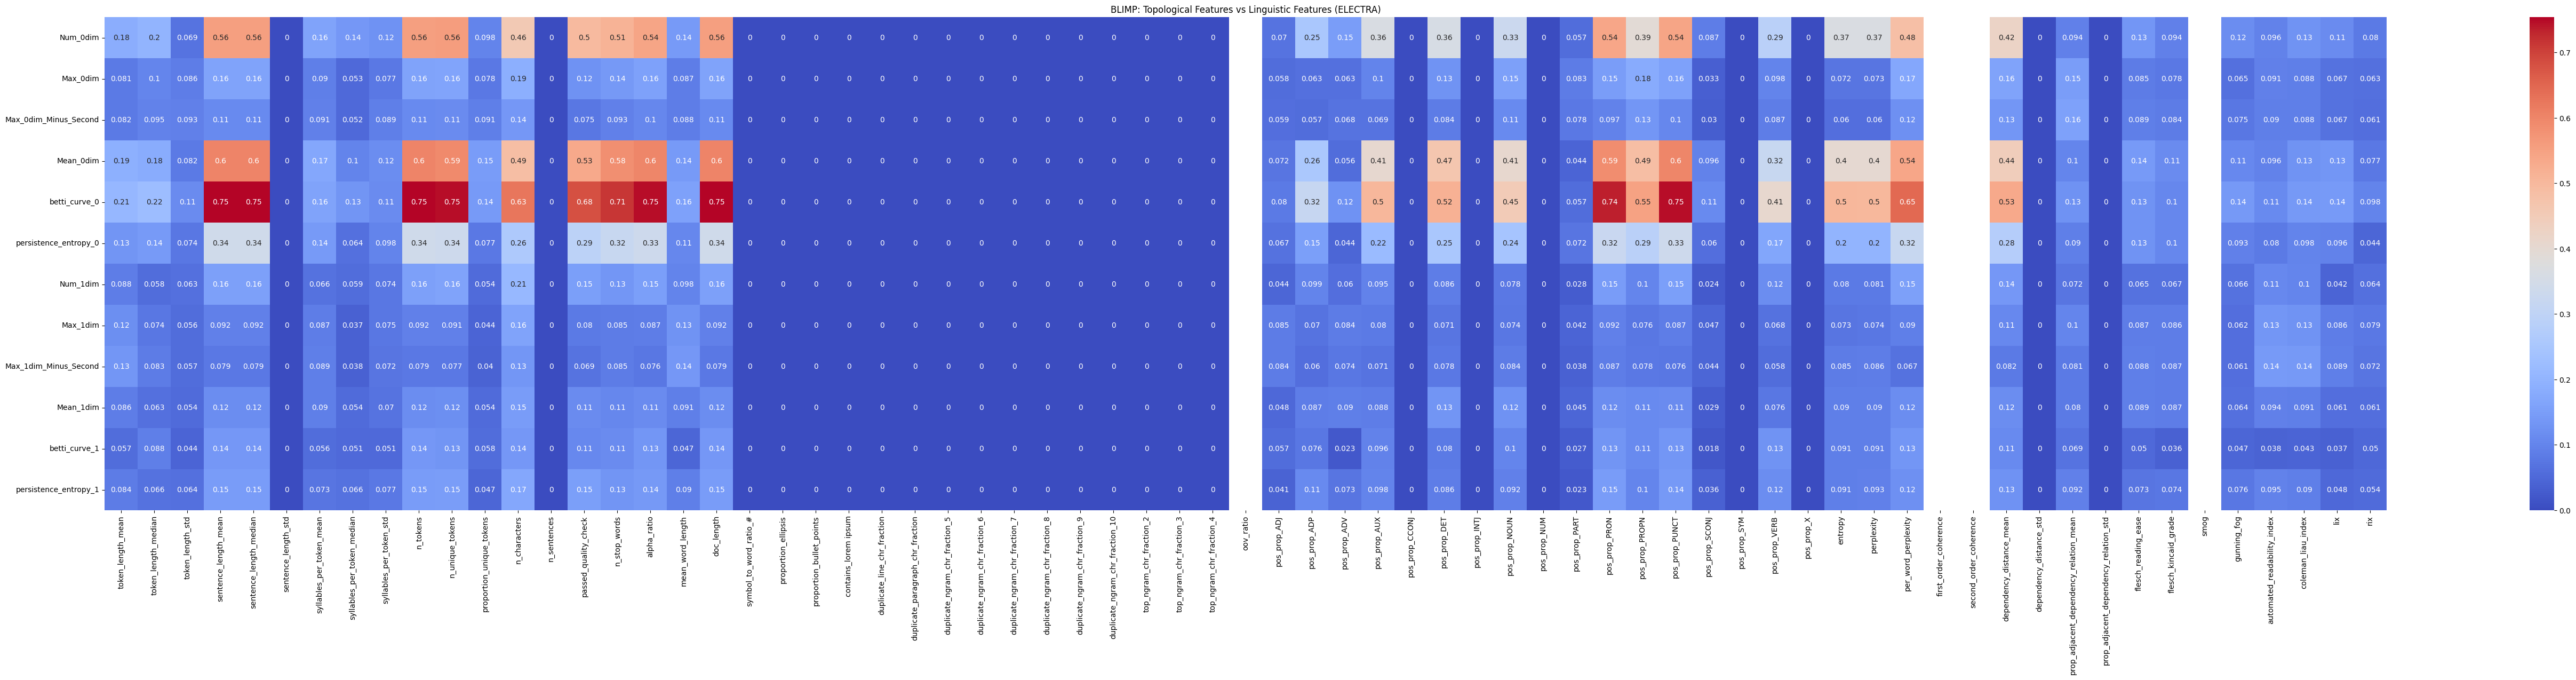

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


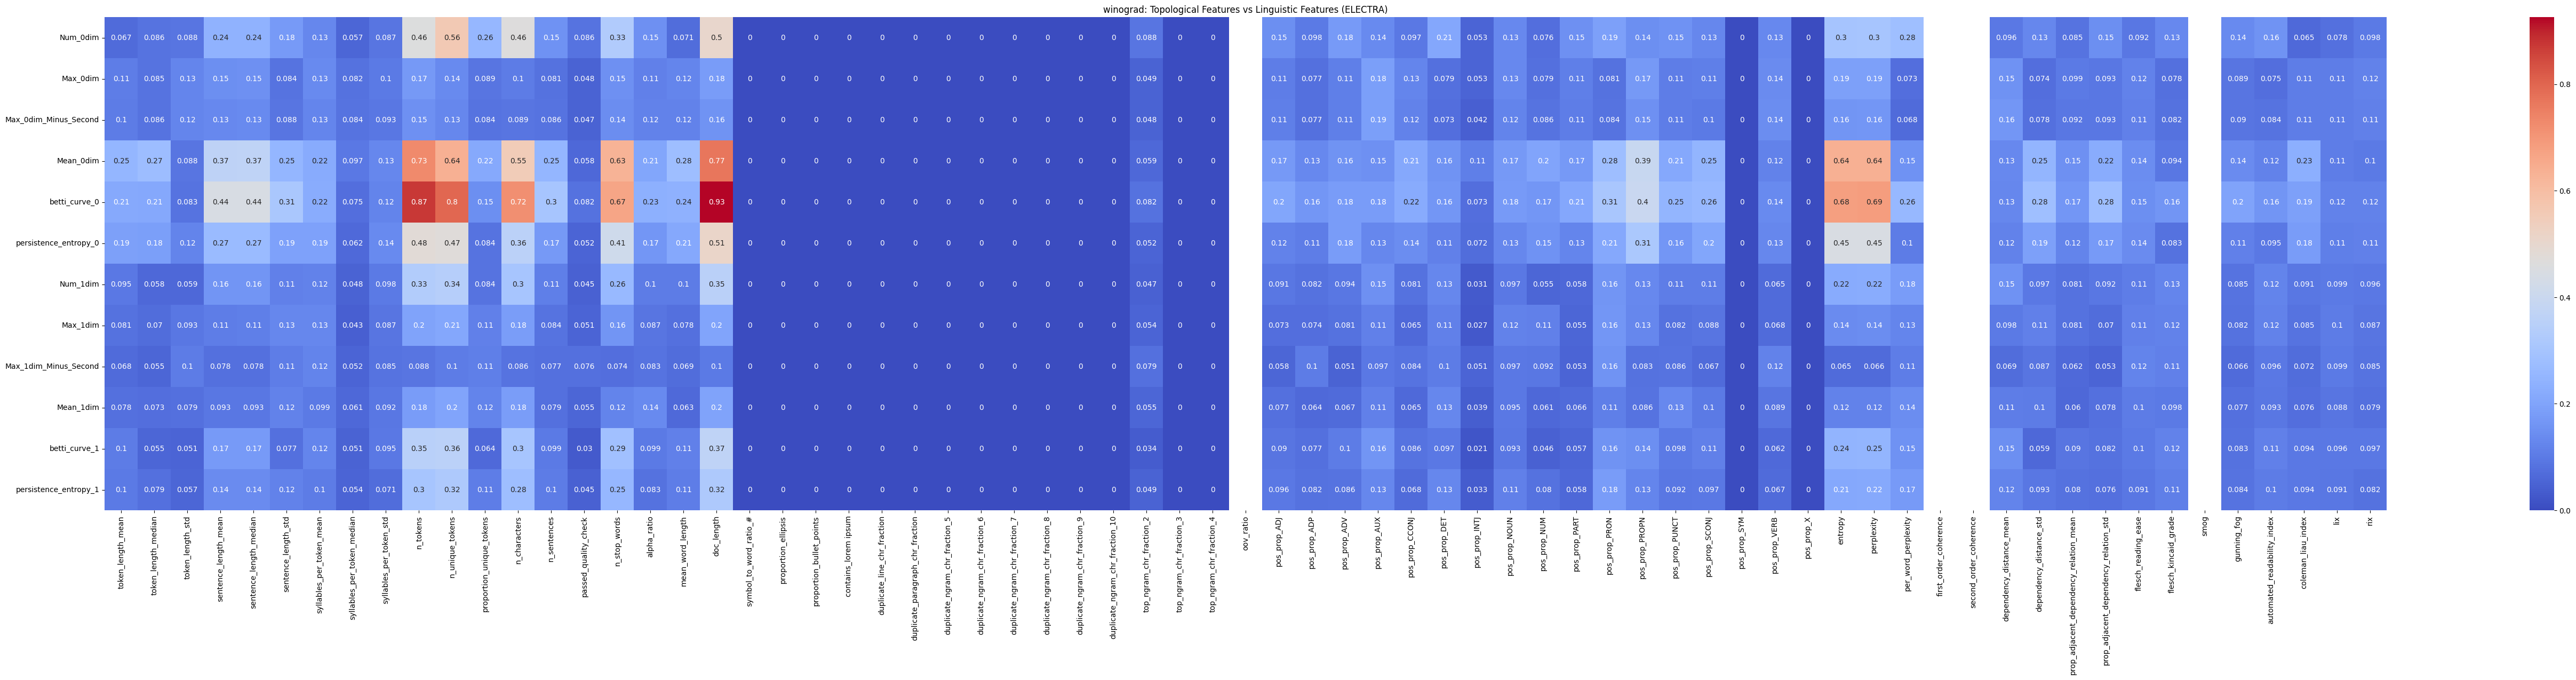

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


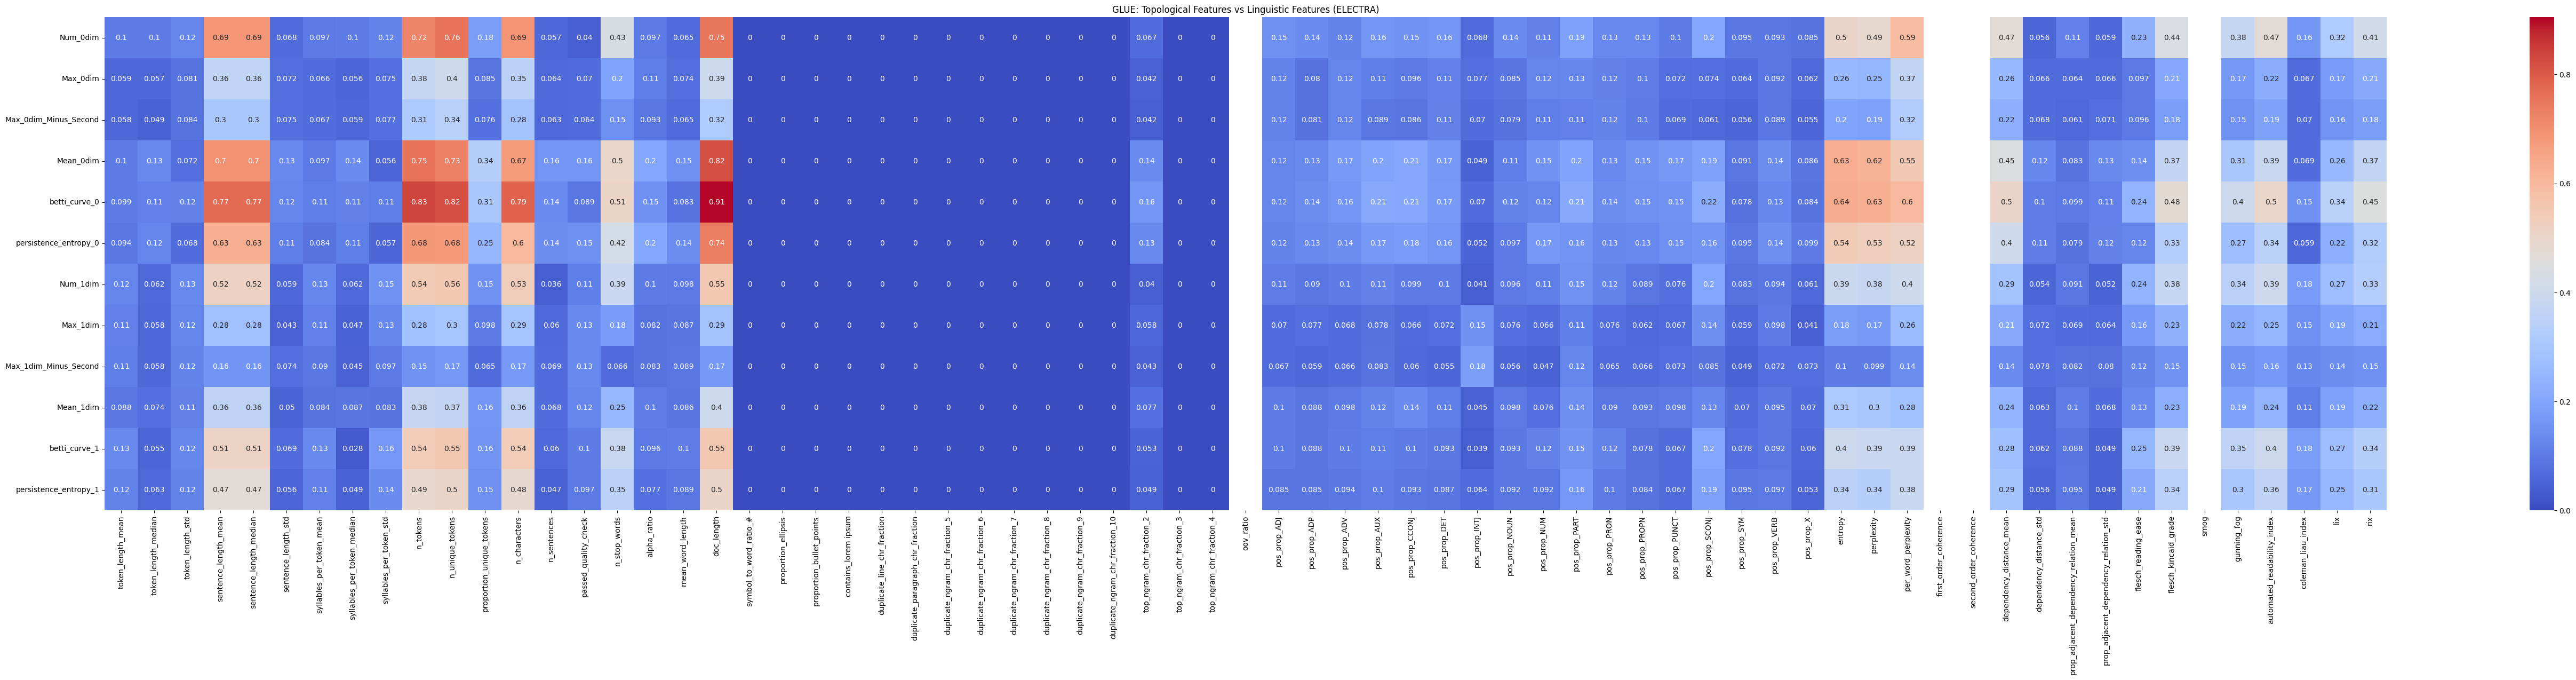

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


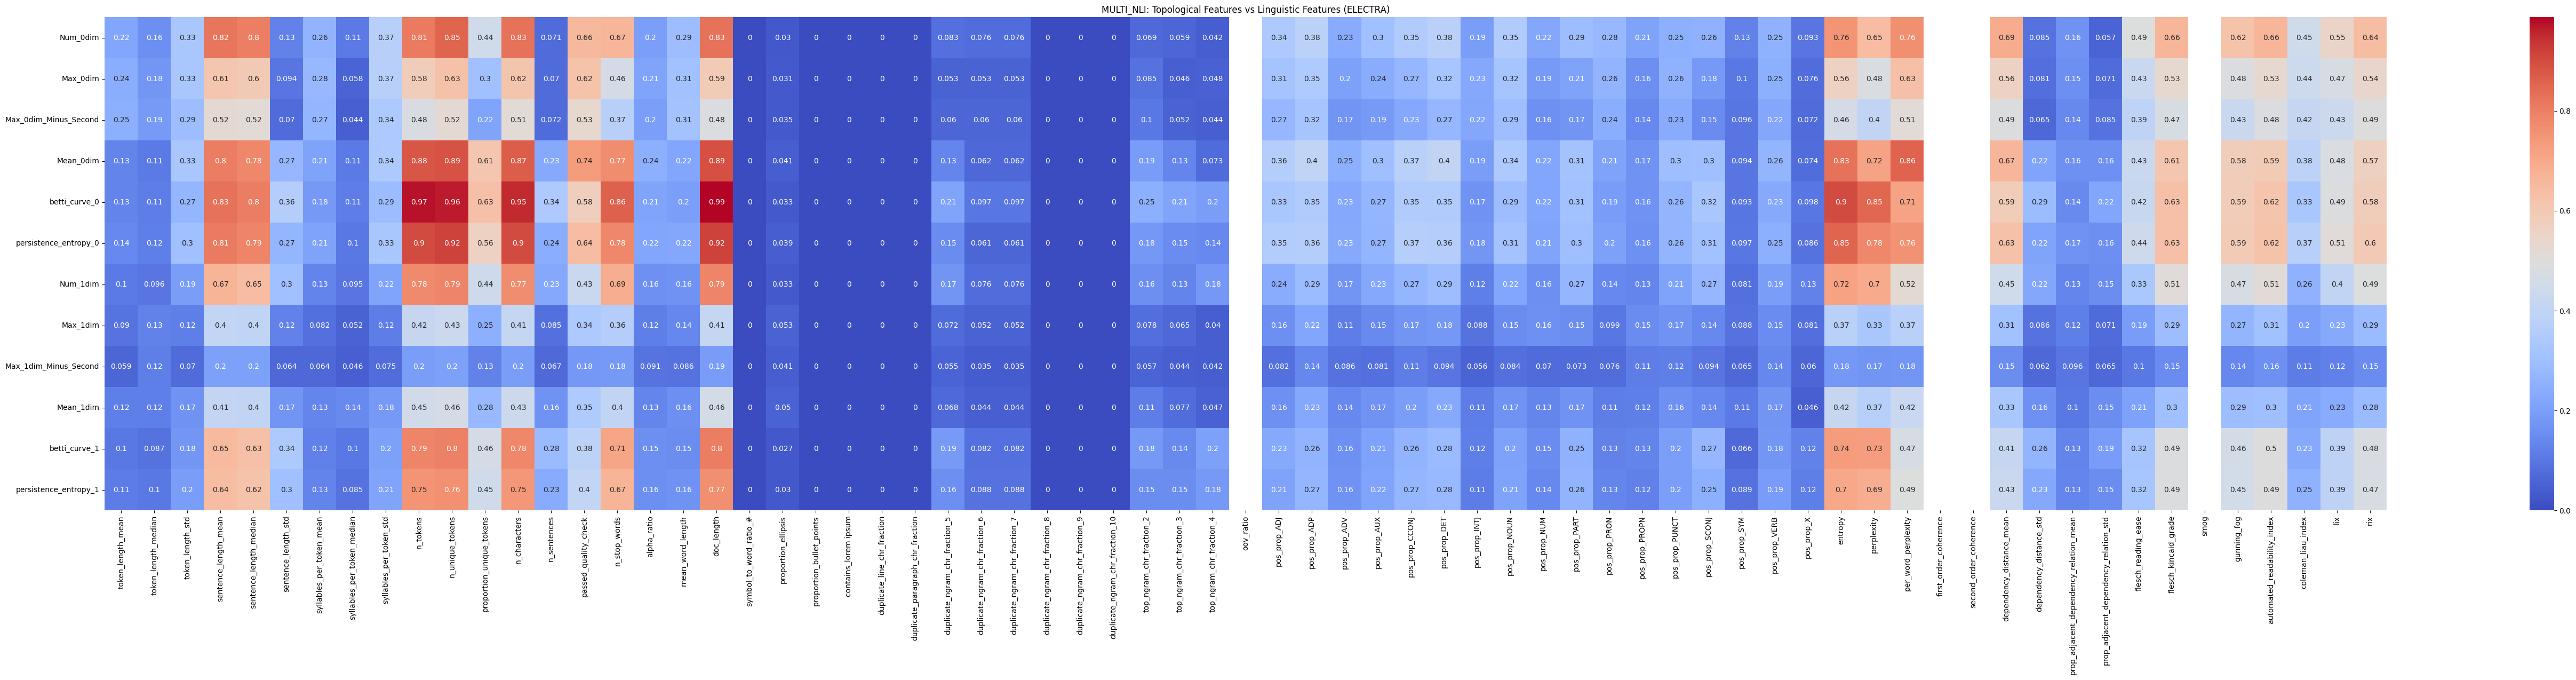

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


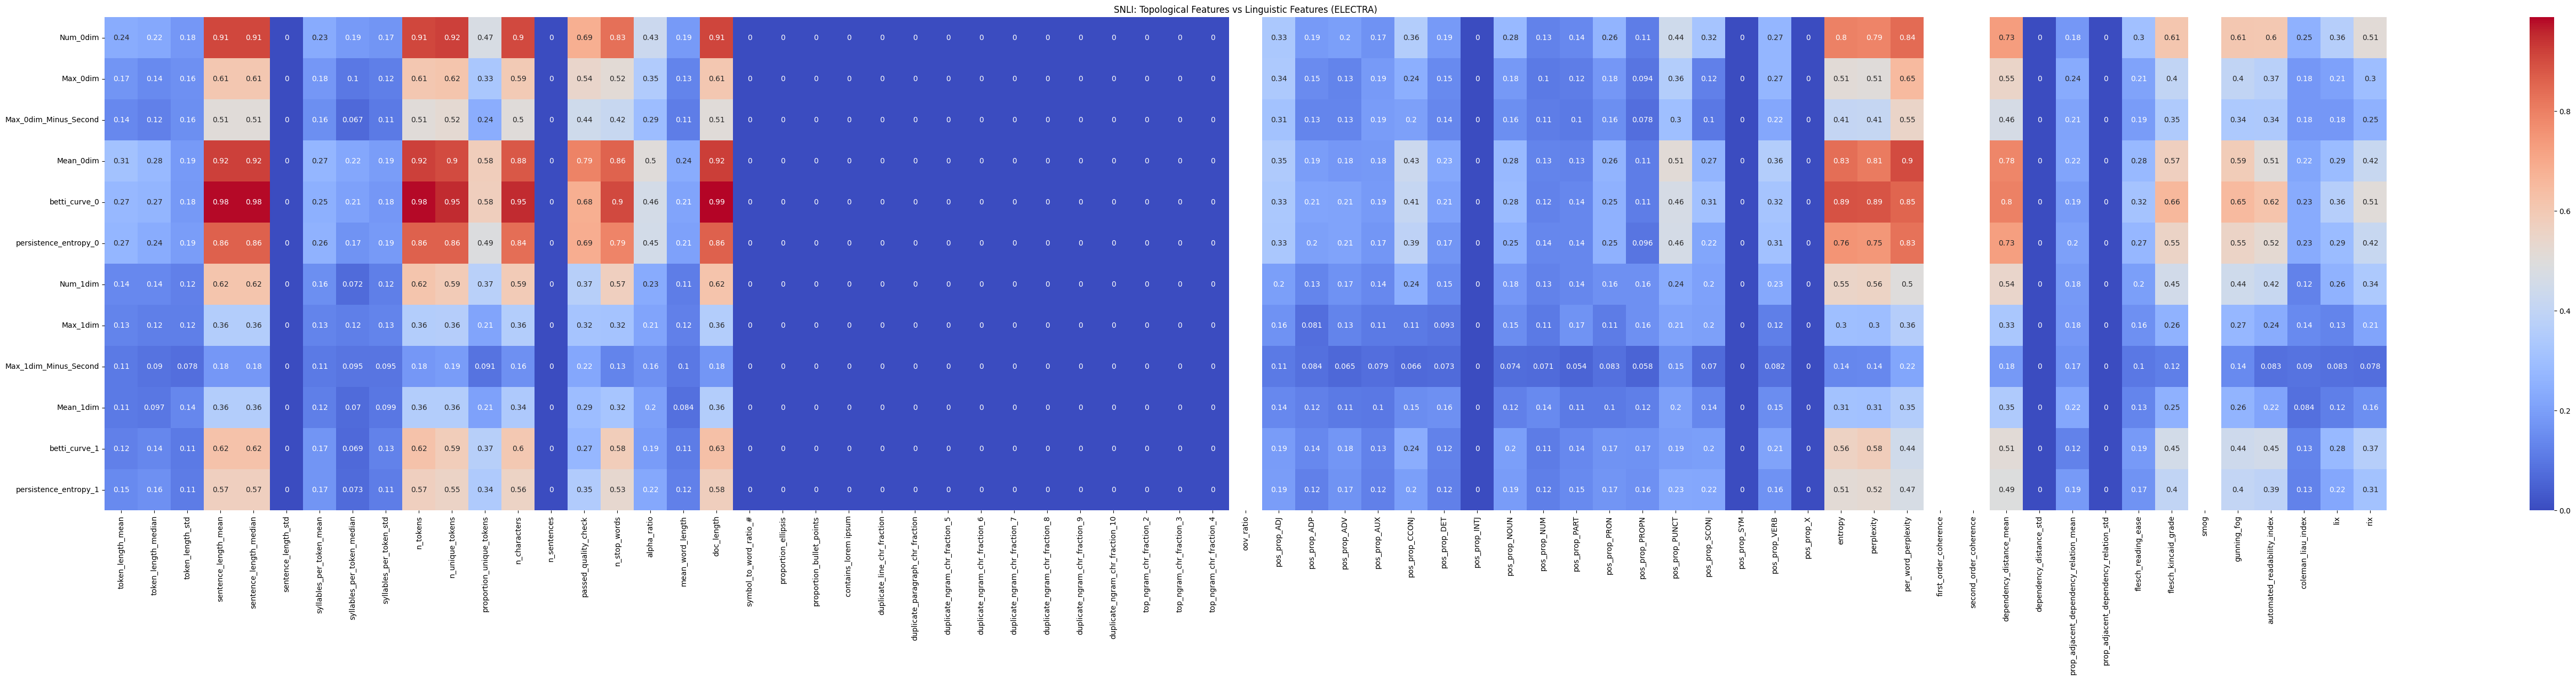

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


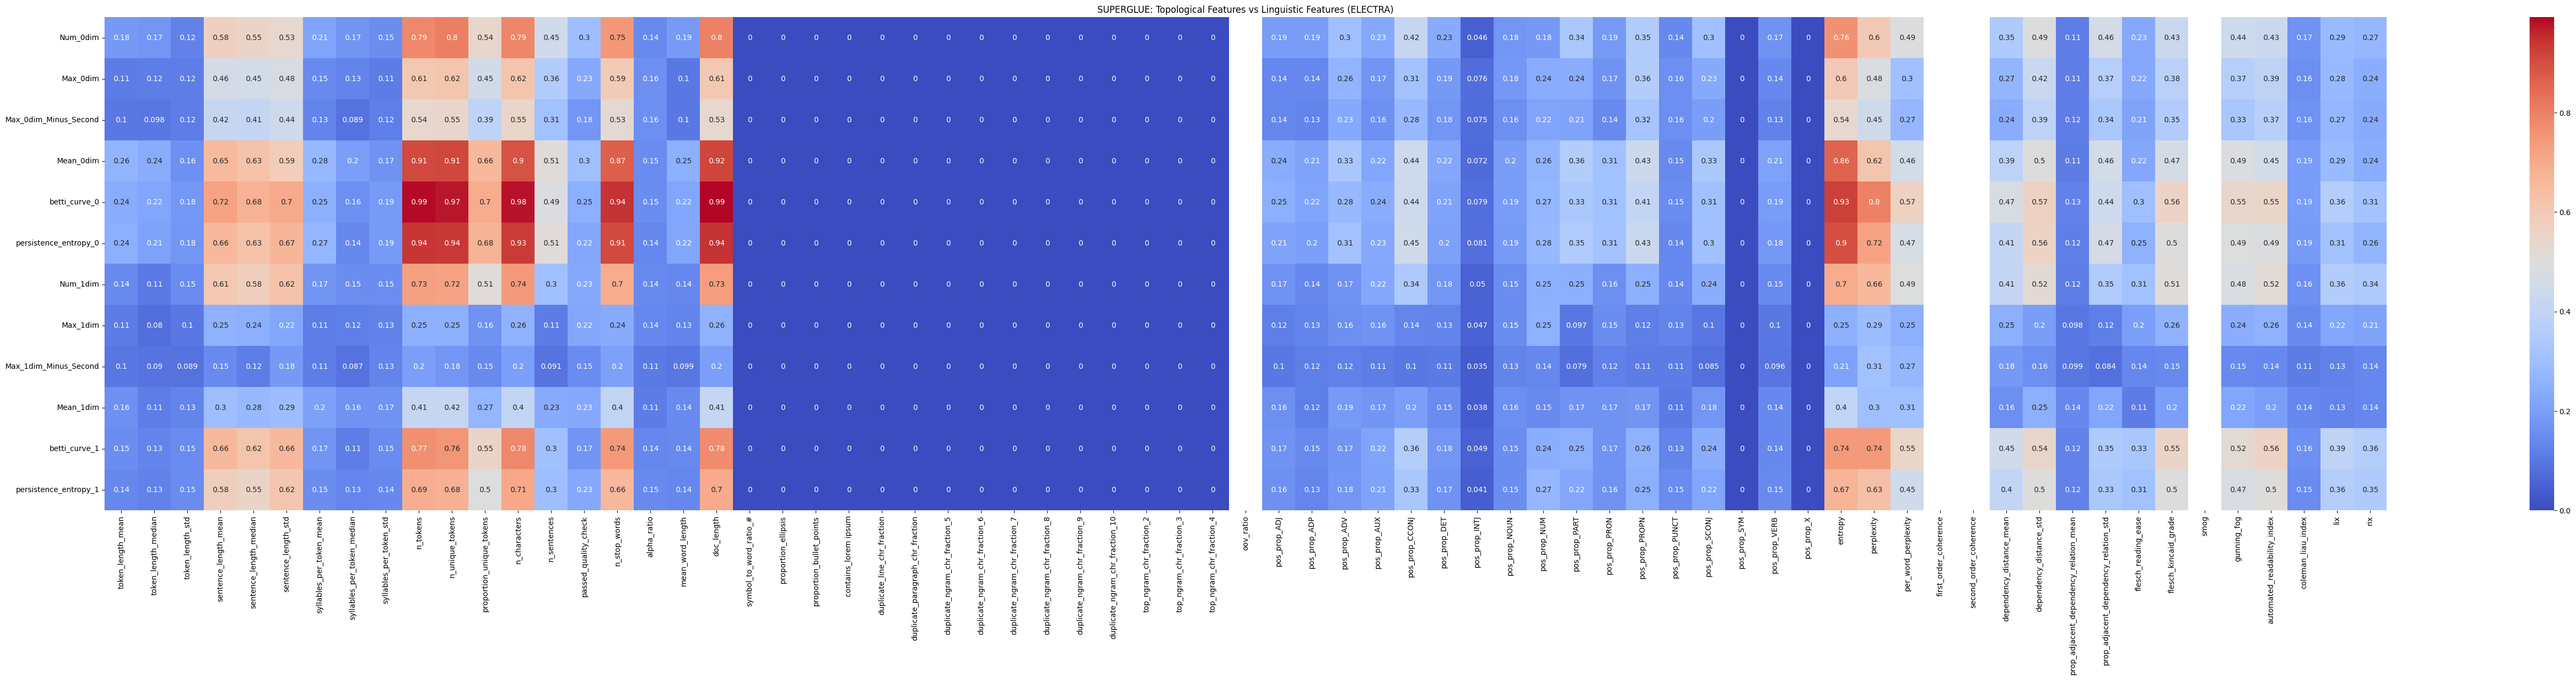

In [28]:
# choose model and dataset
model_id = models[8]
# dataset = datasets[0]

# choose linguistic labels :0
linguistic_label = linguistic_labels[0]
tda_label = tda_labels[0]

# get heatmap!
for dataset in datasets:
    make_heatmap(dataset, model_id, linguistic_label, tda_label)

In [ ]:
# convert features to numpy
tda_features2 = focus_tda_bad.to_numpy()
linguistic_features2 = focus_bad_feat.to_numpy()

# compute pairwise distance correlation matrix
corr_matrix2 = np.zeros((tda_features2.shape[1], linguistic_features2.shape[1]))

for i in range(tda_features2.shape[1]):
    for j in range(linguistic_features2.shape[1]):
        corr_matrix2[i, j] = dcor.distance_correlation(tda_features2[:, i], linguistic_features2[:, j])

# plot heatmap
plt.figure(figsize=(len(linguistic_label), len(tda_label)))
sns.heatmap(corr_matrix2, annot=True, cmap="coolwarm",
            xticklabels= linguistic_label,
            yticklabels= tda_label
            )

# find highest correlated values
red_threshold=0.5
red_cells2 = [(tda_label[i], linguistic_label[j], corr_matrix[i, j]) 
             for i in range(corr_matrix2.shape[0])
             for j in range(corr_matrix2.shape[1])
             if (corr_matrix2[i, j] > red_threshold)]

print("Red cells (row, col, value):")
for cell in red_cells2:
    print(cell)

path_bad = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/heatmaps/{dataset_name}_sen_bad{attempt}.pdf")

plt.title(f"{title2}")
plt.savefig(path_bad)
plt.show()

#Distance Correlation Heatmap

In [ ]:
# difference matrix

# compute pairwise distance correlation matrix
corr_matrix3 = corr_matrix - corr_matrix2

# plot heatmap
plt.figure(figsize=(len(linguistic_label), len(tda_label)))
sns.heatmap(corr_matrix3, annot=True, cmap="coolwarm",
            xticklabels= linguistic_label,
            yticklabels=tda_label
            )

# find highest correlated values
red_threshold=0.5
red_cells3 = [(tda_label[i], linguistic_label[j], corr_matrix3[i, j]) 
             for i in range(corr_matrix3.shape[0])
             for j in range(corr_matrix3.shape[1])
             if (corr_matrix3[i, j] > red_threshold)]

print("Red cells (row, col, value):")
for cell in red_cells3:
    print(cell)

plt.title(f"{dataset_name} Difference Matrix")

path_diff = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/heatmaps/{dataset_name}_sen_diff{attempt}.pdf")

plt.savefig(path_diff)
plt.show()

#Distance Correlation Heatmap